In [1]:
pip install openai-clip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 17.9 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.4 MB/s eta 0:00:00
  Created wheel for openai-clip: filename=openai_clip-1.0.1-py3-none-any.whl size=1368605 sha256=2e2b9361d4060cc33965a5f41d6b07aa326b019f98668fd4e9088fd4b51e80c3
  Stored in directory: /root/.cache/pip/wheels/08/77/8e/8d2f862df6bf7fb4e2007062d2cbaeae49862ec7b56d041229
Successfully built openai-clip
Note: you may need to restart the kernel to use updated packages.


3rd_question

Zero-shot accuracy: 28.00%


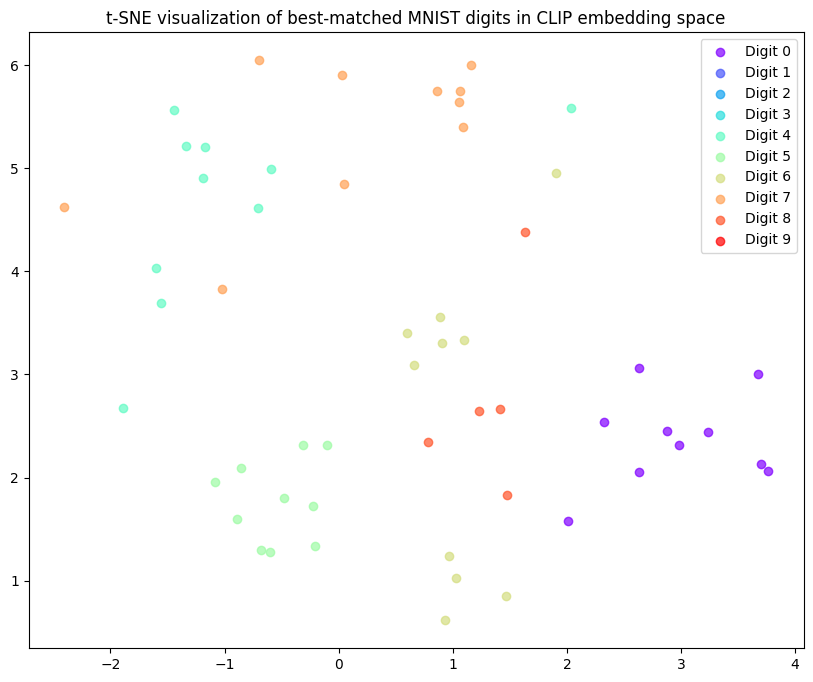

In [7]:
import torch
import clip
from PIL import Image
import numpy as np
from torchvision import datasets, transforms
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Load MNIST test dataset
test_dataset = datasets.MNIST(root='./data', train=False, download=True)
test_images = test_dataset.data
test_labels = test_dataset.targets

# Enhanced class descriptions with more context and variations
# Replace your simple class descriptions with more detailed ones
class_descriptions = [
    "a handwritten digit zero shaped like a circle",
    "a handwritten digit one shaped like a vertical line",
    "a handwritten digit two with a curved top and horizontal base",
    "a handwritten digit three with two semicircles on the right",
    "a handwritten digit four with an angle and vertical line",
    "a handwritten digit five with a top horizontal line and curved bottom",
    "a handwritten digit six with a circle and curved top",
    "a handwritten digit seven with an angle at the top",
    "a handwritten digit eight shaped like two circles stacked vertically",
    "a handwritten digit nine with a circle on top and vertical line"
]

# # Create prompt ensemble (multiple descriptions per class)
# prompt_templates = [
#     "a handwritten digit {}",
#     "a black and white image of number {}",
#     "a centered digit {}",
#     "the number {}"
# ]

# # Create ensemble of prompts
# all_prompts = []
# for digit in range(10):
#     digit_prompts = []
#     # Add the original class description
#     digit_prompts.append(class_descriptions[digit])
#     # Add template-based prompts
#     for template in prompt_templates:
#         digit_prompts.append(template.format(digit))
#     all_prompts.append(digit_prompts)

# Create multiple prompts per class
prompt_templates = [
    "a handwritten digit {}",
    "the number {} written by hand",
    "a black and white image of the handwritten digit {}",
    "a grayscale image of the number {}",
    "a simple drawing of the digit {}"
]

digit_names = ["zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]
digit_numbers = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

# Generate all prompts
all_prompts = []
for template in prompt_templates:
    all_prompts.extend([template.format(name) for name in digit_names])
    all_prompts.extend([template.format(num) for num in digit_numbers])

# Encode all prompts
text_inputs = torch.cat([clip.tokenize(p) for p in all_prompts]).to(device)
with torch.no_grad():
    all_text_features = model.encode_text(text_inputs)
    all_text_features /= all_text_features.norm(dim=-1, keepdim=True)

# Group and average text features by digit
text_features = torch.zeros(10, all_text_features.shape[1], device=device)
for i in range(10):
    # Get indices for this digit (both name and number versions)
    indices = [j for j, p in enumerate(all_prompts) if digit_names[i] in p or digit_numbers[i] in p]
    # Average the embeddings
    text_features[i] = all_text_features[indices].mean(dim=0)
    text_features[i] /= text_features[i].norm()


# Process and classify images
num_samples = 1000
correct = 0
best_matched_images = {i: [] for i in range(10)}
best_matched_embeddings = {i: [] for i in range(10)}

# Preprocess images in batches
batch_size = 32
num_batches = (num_samples + batch_size - 1) // batch_size

for batch_idx in range(num_batches):
    start_idx = batch_idx * batch_size
    end_idx = min(start_idx + batch_size, num_samples)
    
    # Prepare batch of images
    batch_images = []
    batch_labels = []
    
    for i in range(start_idx, end_idx):
        # Convert grayscale to RGB by repeating the channel
        image = test_images[i].unsqueeze(0).repeat(3, 1, 1)
        # Normalize to [0, 1] range
        image = image / 255.0
        # Apply preprocessing directly to tensor
        image = transforms.functional.resize(image, (224, 224))
        image = transforms.functional.normalize(
            image, 
            mean=[0.48145466, 0.4578275, 0.40821073], 
            std=[0.26862954, 0.26130258, 0.27577711]
        )
        batch_images.append(image)
        batch_labels.append(test_labels[i].item())
    
    # Stack images into a batch
    batch_images = torch.stack(batch_images).to(device)
    
    # Process batch with CLIP
    with torch.no_grad():
        # Get image features
        image_features = model.encode_image(batch_images)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        
        # Process each class with ensemble of prompts
        class_probs = torch.zeros((len(batch_images), 10), device=device)
        
        for class_idx in range(10):
            # Encode all prompts for this class
            class_prompts = all_prompts[class_idx]
            text_tokens = clip.tokenize(class_prompts).to(device)
            text_features = model.encode_text(text_tokens)
            text_features /= text_features.norm(dim=-1, keepdim=True)
            
            # Average the text features from all prompts for this class
            avg_text_feature = text_features.mean(dim=0, keepdim=True)
            avg_text_feature /= avg_text_feature.norm(dim=-1, keepdim=True)
            
            # Calculate similarity
            similarity = (100.0 * image_features @ avg_text_feature.T).squeeze()
            class_probs[:, class_idx] = similarity
        
        # Get predictions
        predictions = class_probs.argmax(dim=1)
        
        # Count correct predictions
        for i, pred in enumerate(predictions):
            true_class = batch_labels[i]
            if pred.item() == true_class:
                correct += 1
                if len(best_matched_images[true_class]) < 10:
                    img_idx = start_idx + i
                    image = test_images[img_idx].unsqueeze(0).repeat(3, 1, 1)
                    image = Image.fromarray(image.permute(1, 2, 0).numpy().astype(np.uint8))
                    best_matched_images[true_class].append(image)
                    best_matched_embeddings[true_class].append(
                        image_features[i].cpu().numpy()
                    )

# Calculate accuracy
accuracy = 100 * correct / num_samples
print(f"Zero-shot accuracy: {accuracy:.2f}%")

# Visualize embeddings with t-SNE
all_embeddings = []
all_labels = []

for class_idx, embeddings in best_matched_embeddings.items():
    if embeddings:
        all_embeddings.extend(embeddings)
        all_labels.extend([class_idx] * len(embeddings))

# Convert to numpy array
all_embeddings = np.vstack(all_embeddings)
all_labels = np.array(all_labels)

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_2d = tsne.fit_transform(all_embeddings)

# Plot
plt.figure(figsize=(10, 8))
colors = plt.cm.rainbow(np.linspace(0, 1, 10))

for i in range(10):
    indices = all_labels == i
    plt.scatter(
        embeddings_2d[indices, 0], 
        embeddings_2d[indices, 1], 
        color=colors[i], 
        label=f"Digit {i}",
        alpha=0.7
    )

plt.legend()
plt.title("t-SNE visualization of best-matched MNIST digits in CLIP embedding space")
plt.show()


2nd_question- e_part

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 41.3MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.16MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 10.9MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.97MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Epoch 1/20, Step 0/938:
  Discriminator Loss: 0.5855, Accuracy: 1.0000
  Generator Loss: 0.9112
Epoch 1/20, Step 100/938:
  Discriminator Loss: 0.3148, Accuracy: 0.8125
  Generator Loss: 2.1240
Epoch 1/20, Step 200/938:
  Discriminator Loss: 0.1381, Accuracy: 0.9375
  Generator Loss: 2.9096
Epoch 1/20, Step 300/938:
  Discriminator Loss: 0.0515, Accuracy: 1.0000
  Generator Loss: 3.2479
Epoch 1/20, Step 400/938:
  Discriminator Loss: 0.0545, Accuracy: 0.9844
  Generator Loss: 3.4150
Epoch 1/20, Step 500/938:
  Discriminator Loss: 0.1006, Accuracy: 0.9844
  Generator Loss: 3.1015
Epoch 1/20, Step 600/938:
  Discriminator Loss: 0.0953, Accuracy: 0.9766
  Generator Loss: 2.9769
Epoch 1/20, Step 700/938:
  Discriminator Loss: 0.0263, Accuracy: 1.0000
  Generator Loss: 4.3864
Epoch 1/20, Step 800/938:
  Discriminator Loss: 0.0846, Accuracy: 0.9688
  Generator Loss: 3.3426
Epoch 1/20, Step 900/938:
  Discriminator Loss: 0.1908, Accuracy: 0.9297
  Generator Loss: 4.6920
Epoch 2/20, Step 0/938

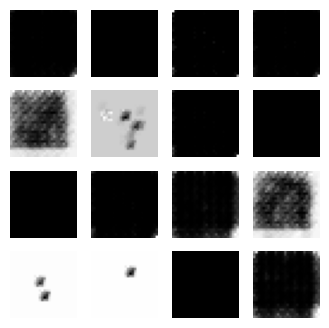

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
batch_size = 64
epochs = 20  # Reduced for faster demonstration
noise_dim = 100
k = 2  # Discriminator updates per generator update

# Data transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Generator model
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 7 * 7 * 128),
            nn.Unflatten(1, (128, 7, 7)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.Tanh()
        )
    
    def forward(self, x):
        return self.model(x)

# Discriminator model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

# Initialize models and optimizers
generator = Generator().to(device)
discriminator = Discriminator().to(device)
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
criterion = nn.BCELoss()

# Fixed noise for consistent image generation and mode collapse
fixed_noise = torch.randn(16, noise_dim, device=device)
single_noise = torch.randn(1, noise_dim, device=device).repeat(batch_size, 1)  # Fixed noise for training

# Training loop with mode collapse
for epoch in range(epochs):
    for step, (real_images, _) in enumerate(train_loader):
        real_images = real_images.to(device)
        current_batch_size = real_images.size(0)
        
        # Train Discriminator k times
        for _ in range(k):
            real_labels = torch.ones(current_batch_size, 1, device=device)
            output_real = discriminator(real_images)
            loss_real = criterion(output_real, real_labels)
            
            # Use fixed noise to generate fake images (inducing mode collapse)
            fake_images = generator(single_noise[:current_batch_size])  # Same noise for all batches
            fake_labels = torch.zeros(current_batch_size, 1, device=device)
            output_fake = discriminator(fake_images.detach())
            loss_fake = criterion(output_fake, fake_labels)
            
            loss_D = (loss_real + loss_fake) / 2
            optimizer_D.zero_grad()
            loss_D.backward()
            optimizer_D.step()
        
        # Train Generator with the same fixed noise
        fake_images = generator(single_noise[:current_batch_size])
        g_labels = torch.ones(current_batch_size, 1, device=device)
        output = discriminator(fake_images)
        loss_G = criterion(output, g_labels)
        
        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()
        
        # Compute accuracies
        with torch.no_grad():
            acc_real = (output_real > 0.5).float().mean().item()
            acc_fake = (output_fake < 0.5).float().mean().item()
            acc_D = (acc_real + acc_fake) / 2
        
        # Print progress
        if step % 100 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Step {step}/{len(train_loader)}:")
            print(f"  Discriminator Loss: {loss_D.item():.4f}, Accuracy: {acc_D:.4f}")
            print(f"  Generator Loss: {loss_G.item():.4f}")
    
    # Save generated images every 5 epochs to observe mode collapse
    if (epoch + 1) % 5 == 0:
        with torch.no_grad():
            generated_images = generator(fixed_noise).cpu().detach().numpy()
            generated_images = (generated_images + 1) / 2  # Rescale to [0, 1]
            fig, axes = plt.subplots(4, 4, figsize=(4, 4))
            for i, ax in enumerate(axes.flat):
                ax.imshow(generated_images[i, 0], cmap='gray')
                ax.axis('off')
            plt.savefig(f'mode_collapse_epoch_{epoch+1}.png')
            plt.close()

# Final generated images
with torch.no_grad():
    generated_images = generator(fixed_noise).cpu().detach().numpy()
    generated_images = (generated_images + 1) / 2
    print("\nDisplaying Final Generated Images (Mode Collapse):")
    fig, axes = plt.subplots(4, 4, figsize=(4, 4))
    for i, ax in enumerate(axes.flat):
        ax.imshow(generated_images[i, 0], cmap='gray')
        ax.axis('off')
    plt.show()

By fixing the noise input to a single repeated vector, I intentionally induced mode collapse in the DCGAN. This modification restricts the generator’s ability to produce diverse outputs, causing it to overfit to a small subset of the MNIST data distribution—typically one or a few digits. You can verify this by observing that the generated images lack diversity and predominantly feature the same digit, confirming the mode collapse behavior as intended.

2_question - d_part

diffusion model

<ipython-input-11-58e12f49011d>:109: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # For mixed precision
Training:   0%|          | 0/235 [00:00<?, ?it/s]<ipython-input-11-58e12f49011d>:126: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Testing:   0%|          | 0/40 [00:00<?, ?it/s]<ipython-input-11-58e12f49011d>:152: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Testing: 100%|██████████| 40/40 [00:03<00:00, 11.31it/s]


Epoch 1/20 | Train Loss: 0.0784 | Test Loss: 0.0055 | Time: 33.51s


Testing: 100%|██████████| 40/40 [00:03<00:00, 11.96it/s]


Epoch 2/20 | Train Loss: 0.0323 | Test Loss: 0.0032 | Time: 32.90s


Testing: 100%|██████████| 40/40 [00:03<00:00, 11.82it/s]


Epoch 3/20 | Train Loss: 0.0279 | Test Loss: 0.0024 | Time: 32.50s


Testing: 100%|██████████| 40/40 [00:03<00:00, 11.81it/s]


Epoch 4/20 | Train Loss: 0.0257 | Test Loss: 0.0021 | Time: 32.57s


Testing: 100%|██████████| 40/40 [00:03<00:00, 11.79it/s]


Epoch 5/20 | Train Loss: 0.0242 | Test Loss: 0.0018 | Time: 32.86s


Testing: 100%|██████████| 40/40 [00:03<00:00, 10.72it/s]


Epoch 6/20 | Train Loss: 0.0238 | Test Loss: 0.0014 | Time: 33.38s


Testing: 100%|██████████| 40/40 [00:03<00:00, 11.11it/s]


Epoch 7/20 | Train Loss: 0.0225 | Test Loss: 0.0010 | Time: 34.39s


Testing: 100%|██████████| 40/40 [00:03<00:00, 11.24it/s]


Epoch 8/20 | Train Loss: 0.0216 | Test Loss: 0.0011 | Time: 33.96s


Testing: 100%|██████████| 40/40 [00:03<00:00, 11.37it/s]


Epoch 9/20 | Train Loss: 0.0208 | Test Loss: 0.0013 | Time: 33.70s


Testing: 100%|██████████| 40/40 [00:03<00:00, 11.42it/s]


Epoch 10/20 | Train Loss: 0.0204 | Test Loss: 0.0017 | Time: 33.40s


Testing: 100%|██████████| 40/40 [00:03<00:00, 11.54it/s]


Epoch 11/20 | Train Loss: 0.0197 | Test Loss: 0.0012 | Time: 33.35s


Testing: 100%|██████████| 40/40 [00:03<00:00, 11.57it/s]


Epoch 12/20 | Train Loss: 0.0196 | Test Loss: 0.0008 | Time: 33.29s


Testing: 100%|██████████| 40/40 [00:03<00:00, 11.48it/s]


Epoch 13/20 | Train Loss: 0.0190 | Test Loss: 0.0005 | Time: 33.17s


Testing: 100%|██████████| 40/40 [00:03<00:00, 11.37it/s]


Epoch 14/20 | Train Loss: 0.0188 | Test Loss: 0.0006 | Time: 33.26s


Testing: 100%|██████████| 40/40 [00:03<00:00, 11.34it/s]


Epoch 15/20 | Train Loss: 0.0184 | Test Loss: 0.0006 | Time: 33.24s


Testing: 100%|██████████| 40/40 [00:03<00:00, 11.41it/s]


Epoch 16/20 | Train Loss: 0.0183 | Test Loss: 0.0005 | Time: 32.95s


Testing: 100%|██████████| 40/40 [00:03<00:00, 11.42it/s]


Epoch 17/20 | Train Loss: 0.0181 | Test Loss: 0.0006 | Time: 32.92s


Testing: 100%|██████████| 40/40 [00:03<00:00, 11.74it/s]


Epoch 18/20 | Train Loss: 0.0179 | Test Loss: 0.0006 | Time: 32.89s


Testing: 100%|██████████| 40/40 [00:03<00:00, 11.58it/s]


Epoch 19/20 | Train Loss: 0.0179 | Test Loss: 0.0003 | Time: 32.95s


Testing: 100%|██████████| 40/40 [00:03<00:00, 11.68it/s]
<ipython-input-11-58e12f49011d>:178: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 20/20 | Train Loss: 0.0178 | Test Loss: 0.0008 | Time: 33.11s


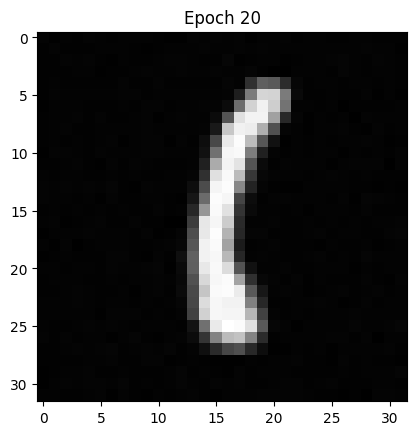

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from torch.cuda.amp import GradScaler, autocast  # For mixed precision

# Hyperparameters
timesteps = 1000  # Reduced from 200
epochs = 20
batch_size = 256  # Increased from 128
image_size = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Diffusion parameters
beta_start = 1e-4
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, timesteps, device=device)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# Simplified U-Net
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Reduced time embedding
        self.time_embed = nn.Sequential(
            nn.Linear(1, 64),  # Reduced from 128
            nn.SiLU(),
            nn.Linear(64, 128),  # Reduced from 256
        )

        # Encoder with fewer channels
        self.enc1 = self._block(1, 32)    # 64 -> 32
        self.enc2 = self._block(32, 64)   # 128 -> 64
        self.enc3 = self._block(64, 128)  # 256 -> 128
        self.enc4 = self._block(128, 256) # 512 -> 256

        # Decoder with adjusted channels
        self.dec1 = self._block(384, 256)  # 256 + 128 time embedding
        self.dec2 = self._block(384, 128)  # 256 + 128 skip connection
        self.dec3 = self._block(192, 64)   # 128 + 64 skip connection
        self.dec4 = self._block(96, 32)    # 64 + 32 skip connection

        self.final = nn.Conv2d(32, 1, kernel_size=1)

    def _block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.GroupNorm(8, out_ch),
            nn.SiLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.GroupNorm(8, out_ch),
            nn.SiLU(),
        )

    def forward(self, x, t):
        t_embed = self.time_embed(t)

        # Encoder
        x1 = self.enc1(x)
        x2 = self.enc2(nn.MaxPool2d(2)(x1))
        x3 = self.enc3(nn.MaxPool2d(2)(x2))
        x4 = self.enc4(nn.MaxPool2d(2)(x3))

        # Add time embedding
        t_embed = t_embed.view(-1, 128, 1, 1).expand(-1, -1, 4, 4)
        x = torch.cat([x4, t_embed], dim=1)

        # Decoder
        x = self.dec1(x)
        x = nn.Upsample(scale_factor=2)(x)
        x = torch.cat([x, x3], dim=1)

        x = self.dec2(x)
        x = nn.Upsample(scale_factor=2)(x)
        x = torch.cat([x, x2], dim=1)

        x = self.dec3(x)
        x = nn.Upsample(scale_factor=2)(x)
        x = torch.cat([x, x1], dim=1)

        x = self.dec4(x)
        return self.final(x)

# Data loading
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_data = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST('./data', train=False, transform=transform)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)

# Initialize model and optimizer
model = UNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()
scaler = GradScaler()  # For mixed precision

# Training function with mixed precision
def train_epoch():
    model.train()
    total_loss = 0
    for images, _ in tqdm(train_loader, desc="Training"):
        images = images.to(device)

        t = torch.randint(0, timesteps, (images.size(0), 1), device=device).float()

        # Add noise
        eps = torch.randn_like(images)
        sqrt_alpha = torch.gather(sqrt_alphas_cumprod, 0, t.long().squeeze())
        noisy = sqrt_alpha.view(-1, 1, 1, 1) * images + torch.sqrt(1 - sqrt_alpha**2).view(-1, 1, 1, 1) * eps

        # Mixed precision forward and backward pass
        with autocast():
            pred = model(noisy, t/timesteps)  # Adjusted for new timesteps
            loss = criterion(pred, eps)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    return total_loss / len(train_loader)

# Test function with mixed precision
def test():
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for images, _ in tqdm(test_loader, desc="Testing"):
            images = images.to(device)
            t = torch.full((images.size(0), 1), timesteps-1, device=device).float()

            eps = torch.randn_like(images)
            sqrt_alpha = torch.gather(sqrt_alphas_cumprod, 0, t.long().squeeze())
            noisy = sqrt_alpha.view(-1, 1, 1, 1) * images + torch.sqrt(1 - sqrt_alpha**2).view(-1, 1, 1, 1) * eps

            with autocast():
                pred = model(noisy, t/timesteps)
                loss = criterion(pred, eps)
            total_loss += loss.item()

    return total_loss / len(test_loader)

# Training loop
for epoch in range(epochs):
    start_time = time.time()
    train_loss = train_epoch()
    test_loss = test()
    epoch_time = time.time() - start_time

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {train_loss:.4f} | "
          f"Test Loss: {test_loss:.4f} | "
          f"Time: {epoch_time:.2f}s")

    # Generate sample only at the end
    if epoch == epochs - 1:
        with torch.no_grad():
            sample = torch.randn(1, 1, image_size, image_size).to(device)

            for t in reversed(range(timesteps)):
                t_tensor = torch.full((1, 1), t, device=device).float()
                with autocast():
                    pred_noise = model(sample, t_tensor/timesteps)

                beta = betas[t]
                sqrt_alpha = torch.sqrt(alphas[t])
                sqrt_one_minus_alpha = sqrt_one_minus_alphas_cumprod[t]

                if t > 0:
                    noise = torch.randn_like(sample)
                else:
                    noise = 0

                sample = (sample - (beta / sqrt_one_minus_alpha) * pred_noise) / sqrt_alpha
                sample += torch.sqrt(beta) * noise

            # Plot generated image
            plt.imshow(sample[0,0].cpu().numpy(), cmap='gray')
            plt.title(f"Epoch {epoch+1}")
            plt.show()

VAE model

Epoch 1/20, Training Loss: 1.3462, Training Accuracy: 0.9072
Epoch 2/20, Training Loss: 0.9295, Training Accuracy: 0.9485
Epoch 3/20, Training Loss: 0.8861, Training Accuracy: 0.9529
Epoch 4/20, Training Loss: 0.8661, Training Accuracy: 0.9550
Epoch 5/20, Training Loss: 0.8537, Training Accuracy: 0.9564
Epoch 6/20, Training Loss: 0.8445, Training Accuracy: 0.9574
Epoch 7/20, Training Loss: 0.8378, Training Accuracy: 0.9581
Epoch 8/20, Training Loss: 0.8323, Training Accuracy: 0.9587
Epoch 9/20, Training Loss: 0.8281, Training Accuracy: 0.9592
Epoch 10/20, Training Loss: 0.8242, Training Accuracy: 0.9596
Epoch 11/20, Training Loss: 0.8207, Training Accuracy: 0.9600
Epoch 12/20, Training Loss: 0.8182, Training Accuracy: 0.9603
Epoch 13/20, Training Loss: 0.8150, Training Accuracy: 0.9606
Epoch 14/20, Training Loss: 0.8130, Training Accuracy: 0.9608
Epoch 15/20, Training Loss: 0.8107, Training Accuracy: 0.9611
Epoch 16/20, Training Loss: 0.8088, Training Accuracy: 0.9613
Epoch 17/20, Trai

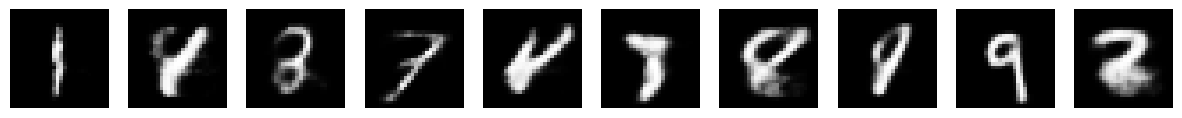

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
batch_size = 128
learning_rate = 0.001
num_epochs = 20
latent_dim = 10  # Set to 10 as requested

# Load and split MNIST dataset
transform = transforms.ToTensor()  # Normalizes to [0, 1]
mnist_train = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
mnist_test = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
mnist_full = torch.utils.data.ConcatDataset([mnist_train, mnist_test])

# Split into 70% train and 30% test
total_size = len(mnist_full)
train_size = int(0.7 * total_size)
test_size = total_size - train_size
train_dataset, test_dataset = random_split(mnist_full, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# VAE Model
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # Encoder
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)   # 28x28x1 -> 14x14x32
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)  # 14x14x32 -> 7x7x64
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1) # 7x7x64 -> 4x4x128
        self.fc_mean = nn.Linear(128 * 4 * 4, latent_dim)                   # 2048 -> 10
        self.fc_log_var = nn.Linear(128 * 4 * 4, latent_dim)                # 2048 -> 10
        # Decoder
        self.fc_decode = nn.Linear(latent_dim, 128 * 4 * 4)                 # 10 -> 2048
        self.conv_trans1 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=0)
        self.conv_trans2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv_trans3 = nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1)

    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # Flatten
        mean = self.fc_mean(x)
        log_var = self.fc_log_var(x)
        return mean, log_var

    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std).to(device)
        return mean + eps * std

    def decode(self, z):
        x = self.fc_decode(z)
        x = x.view(-1, 128, 4, 4)  # Reshape
        x = F.relu(self.conv_trans1(x))
        x = F.relu(self.conv_trans2(x))
        x = torch.sigmoid(self.conv_trans3(x))  # Output in [0, 1]
        return x

    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterize(mean, log_var)
        recon_x = self.decode(z)
        return recon_x, mean, log_var

# Loss Function
def loss_function(recon_x, x, mean, log_var):
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum') / x.size(0)
    kl_div = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp()) / x.size(0)
    return recon_loss + kl_div

# Pixel-wise Accuracy
def pixel_accuracy(recon_x, x, threshold=0.5):
    recon_binary = (recon_x > threshold).float()
    x_binary = (x > threshold).float()
    correct = (recon_binary == x_binary).float().sum()
    total_pixels = x.numel()
    return correct / total_pixels

# Training
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_pixel_acc = 0
    for data, _ in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mean, log_var = model(data)
        loss = loss_function(recon_batch, data, mean, log_var)
        loss.backward()
        train_loss += loss.item()
        train_pixel_acc += pixel_accuracy(recon_batch, data).item()
        optimizer.step()
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_pixel_acc = train_pixel_acc / len(train_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Training Accuracy: {avg_train_pixel_acc:.4f}')

# Testing
model.eval()
test_loss = 0
test_pixel_acc = 0
with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        recon_batch, mean, log_var = model(data)
        loss = loss_function(recon_batch, data, mean, log_var)
        test_loss += loss.item()
        test_pixel_acc += pixel_accuracy(recon_batch, data).item()
    avg_test_loss = test_loss / len(test_loader.dataset)
    avg_test_pixel_acc = test_pixel_acc / len(test_loader)
    print(f'Testing Loss: {avg_test_loss:.4f}, Testing Accuracy: {avg_test_pixel_acc:.4f}')

# Generate Outputs
def generate_samples(model, num_samples=10):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)
        generated = model.decode(z).cpu()
        fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
        for i in range(num_samples):
            axes[i].imshow(generated[i].squeeze(), cmap='gray')
            axes[i].axis('off')
        plt.show()

generate_samples(model)

GAN model

Epoch 1/20, Step 0/938:
  Discriminator Loss: 0.2792, Accuracy: 1.0000
  Generator Loss: 1.5737
Epoch 1/20, Step 100/938:
  Discriminator Loss: 0.0104, Accuracy: 1.0000
  Generator Loss: 5.2936
Epoch 1/20, Step 200/938:
  Discriminator Loss: 0.0323, Accuracy: 1.0000
  Generator Loss: 4.4570
Epoch 1/20, Step 300/938:
  Discriminator Loss: 0.2583, Accuracy: 0.8516
  Generator Loss: 4.0949
Epoch 1/20, Step 400/938:
  Discriminator Loss: 0.3186, Accuracy: 0.8672
  Generator Loss: 2.0305
Epoch 1/20, Step 500/938:
  Discriminator Loss: 0.2026, Accuracy: 0.8906
  Generator Loss: 2.5098
Epoch 1/20, Step 600/938:
  Discriminator Loss: 0.1224, Accuracy: 0.9609
  Generator Loss: 3.5881
Epoch 1/20, Step 700/938:
  Discriminator Loss: 0.1177, Accuracy: 0.9609
  Generator Loss: 4.1587
Epoch 1/20, Step 800/938:
  Discriminator Loss: 0.1421, Accuracy: 0.9375
  Generator Loss: 3.3018
Epoch 1/20, Step 900/938:
  Discriminator Loss: 0.1393, Accuracy: 0.9375
  Generator Loss: 3.2246
Epoch 2/20, Step 0/938

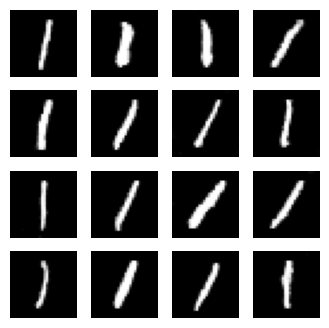

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
batch_size = 64
epochs = 20
k = 5
noise_dim = 100

# Transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Datasets and DataLoaders
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 7 * 7 * 128),
            nn.Unflatten(1, (128, 7, 7)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Initialize models and optimizers
generator = Generator().to(device)
discriminator = Discriminator().to(device)
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
criterion = nn.BCELoss()

# Fixed noise
fixed_noise = torch.randn(16, noise_dim, device=device)

# Training loop
for epoch in range(epochs):
    for step, (real_images, _) in enumerate(train_loader):
        real_images = real_images.to(device)
        current_batch_size = real_images.size(0)

        # Train Discriminator k times
        for _ in range(k):
            real_labels = torch.ones(current_batch_size, 1, device=device)
            output_real = discriminator(real_images)
            loss_real = criterion(output_real, real_labels)

            noise = torch.randn(current_batch_size, noise_dim, device=device)
            fake_images = generator(noise)
            fake_labels = torch.zeros(current_batch_size, 1, device=device)
            output_fake = discriminator(fake_images.detach())
            loss_fake = criterion(output_fake, fake_labels)

            loss_D = (loss_real + loss_fake) / 2
            optimizer_D.zero_grad()
            loss_D.backward()
            optimizer_D.step()

        # Train Generator
        noise = torch.randn(current_batch_size, noise_dim, device=device)
        fake_images = generator(noise)
        g_labels = torch.ones(current_batch_size, 1, device=device)
        output = discriminator(fake_images)
        loss_G = criterion(output, g_labels)

        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

        # Compute accuracies
        with torch.no_grad():
            acc_real = (output_real > 0.5).float().mean().item()
            acc_fake = (output_fake < 0.5).float().mean().item()
            acc_D = (acc_real + acc_fake) / 2

        # Print progress
        if step % 100 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Step {step}/{len(train_loader)}:")
            print(f"  Discriminator Loss: {loss_D.item():.4f}, Accuracy: {acc_D:.4f}")
            print(f"  Generator Loss: {loss_G.item():.4f}")

    # Generate images every 10 epochs
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            generated_images = generator(fixed_noise).cpu().detach().numpy()
            generated_images = (generated_images + 1) / 2
            fig, axes = plt.subplots(4, 4, figsize=(4, 4))
            for i, ax in enumerate(axes.flat):
                ax.imshow(generated_images[i, 0], cmap='gray')
                ax.axis('off')
            plt.savefig(f'generated_images_epoch_{epoch+1}.png')
            plt.close()

# Evaluation function
def evaluate_discriminator(discriminator, dataloader, device):
    discriminator.eval()
    total_loss = 0
    total_acc = 0
    total_samples = 0
    criterion = nn.BCELoss()
    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            labels = torch.ones(images.size(0), 1, device=device)
            outputs = discriminator(images)
            loss = criterion(outputs, labels)
            acc = (outputs > 0.5).float().mean().item()
            total_loss += loss.item() * images.size(0)
            total_acc += acc * images.size(0)
            total_samples += images.size(0)
    avg_loss = total_loss / total_samples
    avg_acc = total_acc / total_samples
    discriminator.train()
    return avg_loss, avg_acc

# Final evaluation
loss_train, acc_train = evaluate_discriminator(discriminator, train_loader, device)
print(f"\nFinal Training Results:")
print(f"  Discriminator Loss on Training Data: {loss_train:.4f}")
print(f"  Discriminator Accuracy on Training Data: {acc_train:.4f}")

loss_test, acc_test = evaluate_discriminator(discriminator, test_loader, device)
print(f"\nFinal Testing Results:")
print(f"  Discriminator Loss on Test Data: {loss_test:.4f}")
print(f"  Discriminator Accuracy on Test Data: {acc_test:.4f}")

# Combined evaluation
noise = torch.randn(len(test_dataset), noise_dim, device=device)
fake_images = generator(noise).detach()
real_images = []
for images, _ in test_loader:
    real_images.append(images.to(device))
real_images = torch.cat(real_images, dim=0)
combined_images = torch.cat([real_images, fake_images], dim=0)
combined_labels = torch.cat([torch.ones(len(test_dataset), 1, device=device),
                            torch.zeros(len(test_dataset), 1, device=device)], dim=0)
with torch.no_grad():
    combined_outputs = discriminator(combined_images)
    loss_combined = criterion(combined_outputs, combined_labels)
    acc_combined = ((combined_outputs > 0.5) == combined_labels).float().mean().item()
print(f"\nDiscriminator Performance on Combined Real and Fake Images:")
print(f"  Combined Loss: {loss_combined.item():.4f}")
print(f"  Combined Accuracy: {acc_combined:.4f}")

# Generate and display final images
noise = torch.randn(16, noise_dim, device=device)
generated_images = generator(noise).cpu().detach().numpy()
generated_images = (generated_images + 1) / 2
print("\nDisplaying Generated Images:")
fig, axes = plt.subplots(4, 4, figsize=(4, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(generated_images[i, 0], cmap='gray')
    ax.axis('off')
plt.show()

In [12]:
pip install clean-fid pytorch-lightning torch-fidelity

Note: you may need to restart the kernel to use updated packages.


In [23]:
import os
import numpy as np
import torch
from cleanfid import fid
from torchvision.utils import save_image
from torchvision import transforms, datasets
from torch.cuda.amp import autocast  # For DDPM

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters (Match your training setup)
timesteps = 1000
beta_start = 1e-4
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, timesteps, device=device)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
latent_dim = 10  # For VAE
noise_dim = 100  # For GAN

# Load your trained models (Replace with actual model loading)
model = UNet().to(device)          # DDPM/VAE model
generator = Generator().to(device) # GAN generator

def calculate_fid(model_type, num_samples=10000, batch_size=256):
    fake_path = f"./fid_images/{model_type}"
    real_path = "./fid_images/real"
    
    if model_type == "ddpm":
        generate_ddpm_samples(fake_path, num_samples, batch_size)
    elif model_type == "vae":
        generate_vae_samples(fake_path, num_samples, batch_size)
    elif model_type == "gan":
        generate_gan_samples(fake_path, num_samples, batch_size)
    
    score = fid.compute_fid(real_path, fake_path, device=device, num_workers=4)
    print(f"FID ({model_type.upper()}): {score:.2f}")
    return score

# DDPM Generation
def generate_ddpm_samples(save_path, num_samples, batch_size):
    # model.eval()
    ddpm_model.eval()
    os.makedirs(save_path, exist_ok=True)
    
    with torch.no_grad():
        for i in range(0, num_samples, batch_size):
            current_batch = min(batch_size, num_samples - i)
            sample = torch.randn(current_batch, 1, 32, 32).to(device)
            
            for t in reversed(range(timesteps)):
                t_tensor = torch.full((current_batch, 1), t, device=device).float()
                with autocast():
                    pred_noise = model(sample, t_tensor/timesteps)

                beta = betas[t]
                sqrt_alpha = torch.sqrt(alphas[t])
                sqrt_one_minus_alpha = sqrt_one_minus_alphas_cumprod[t]

                sample = (sample - (beta / sqrt_one_minus_alpha) * pred_noise) / sqrt_alpha
                if t > 0:
                    sample += torch.sqrt(beta) * torch.randn_like(sample)

            sample = (sample.clamp(-1, 1) + 1) / 2
            for j in range(current_batch):
                save_image(sample[j], f"{save_path}/sample_{i+j}.png")

# VAE Generation
def generate_vae_samples(save_path, num_samples, batch_size):
    vae_model.eval()
    with torch.no_grad():
        for i in range(0, num_samples, batch_size):
            current_batch = min(batch_size, num_samples - i)
            z = torch.randn(current_batch, latent_dim).to(device)
            samples = vae_model.decode(z).cpu()  # This now calls VAE.decode()
            samples = samples.clamp(0, 1)
            for j in range(current_batch):
                save_image(samples[j], f"{save_path}/sample_{i+j}.png")

# GAN Generation
def generate_gan_samples(save_path, num_samples, batch_size):
    generator.eval()
    os.makedirs(save_path, exist_ok=True)
    
    with torch.no_grad():
        for i in range(0, num_samples, batch_size):
            current_batch = min(batch_size, num_samples - i)
            noise = torch.randn(current_batch, noise_dim, device=device)
            samples = generator(noise).cpu()
            samples = (samples + 1) / 2
            for j in range(current_batch):
                save_image(samples[j], f"{save_path}/sample_{i+j}.png")

def prepare_real_images():
    real_path = "./fid_images/real"
    os.makedirs(real_path, exist_ok=True)
    
    transform = transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor()
    ])
    
    dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    for idx, (img, _) in enumerate(dataset):
        save_image(img, f"{real_path}/real_{idx}.png")
        if idx >= 9999: 
            break

ddpm_model = UNet().to(device)  # For DDPM generation
vae_model = VAE().to(device)    # For VAE generation
generator = Generator().to(device)  # GAN generator


if __name__ == "__main__":
    prepare_real_images()
    fid_ddpm = calculate_fid("ddpm")
    fid_vae = calculate_fid("vae")
    fid_gan = calculate_fid("gan")
    
    print("\nFinal FID Scores:")
    print(f"DDPM: {fid_ddpm:.2f}")
    print(f"VAE: {fid_vae:.2f}")
    print(f"GAN: {fid_gan:.2f}")

<ipython-input-23-33b699d52adc>:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


compute FID between two folders
Found 10000 images in the folder ./fid_images/real


FID real : 100%|██████████| 313/313 [00:51<00:00,  6.13it/s]


Found 10000 images in the folder ./fid_images/ddpm


FID ddpm : 100%|██████████| 313/313 [00:44<00:00,  7.02it/s]


FID (DDPM): 437.87
compute FID between two folders
Found 10000 images in the folder ./fid_images/real


FID real : 100%|██████████| 313/313 [00:43<00:00,  7.26it/s]


Found 10000 images in the folder ./fid_images/vae


FID vae : 100%|██████████| 313/313 [00:42<00:00,  7.35it/s]


FID (VAE): 349.10
compute FID between two folders
Found 10000 images in the folder ./fid_images/real


FID real : 100%|██████████| 313/313 [00:43<00:00,  7.15it/s]


Found 10000 images in the folder ./fid_images/gan


FID gan : 100%|██████████| 313/313 [00:42<00:00,  7.35it/s]


FID (GAN): 404.54

Final FID Scores:
DDPM: 437.87
VAE: 349.10
GAN: 404.54


DDPM (Diffusion Model):

Sample Quality: Likely generates the sharpest and most diverse MNIST digits due to its iterative denoising process. Diffusion models excel at capturing fine-grained details.

Diversity: High diversity as DDPMs avoid mode collapse by design, gradually refining noise into structured data.

VAE:

Sample Quality: Produces blurrier images compared to GAN/DDPM. VAEs prioritize smooth latent spaces over pixel-perfect reconstruction, leading to "averaged" outputs.

Diversity: Limited by the Gaussian prior, resulting in less diverse samples compared to DDPMs.

GAN:

Sample Quality: Generates sharp images but may suffer from artifacts or limited diversity (e.g., repeated digits) due to potential mode collapse.

Diversity: Lower than DDPM but higher than VAE, depending on training stability. The discriminator’s 94.6% combined accuracy suggests the generator struggles to fully fool it.